In [1]:
import pandas as pd
import numpy as np
import itertools as it

import pickle as pcl

from scipy.spatial.distance import cdist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

from collections import Counter

# Get "Set2" colors from ColorBrewer (all colorbrewer scales: http://bl.ocks.org/mbostock/5577023)
#set2 = brewer2mpl.get_map('Set2', 'qualitative', 8).mpl_colors

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import MeanShift

In [2]:
from palettable.tableau import GreenOrange_12
from palettable.colorbrewer.sequential import YlGnBu_4, YlGnBu_5

cmap = GreenOrange_12.hex_colors
cmap_seq = YlGnBu_5.hex_colors

In [3]:
import hightolowz

In [4]:
redshift = '3p95' # '5p03'
redshift_str = '3.95' # '5.03'
selection = 'sfr'

In [5]:
dgal_random_r20 = pd.read_csv('data/r200/dgal_%s_%s_r20_random.csv' % (selection, redshift))
dgal_random_r12p5 = pd.read_csv('data/r200/dgal_%s_%s_r12.5_random.csv' % (selection, redshift))
dgal_random_r7p5 = pd.read_csv('data/r200/dgal_%s_%s_r7.5_random.csv' % (selection, redshift))
dgal_random_r5 = pd.read_csv('data/r200/dgal_%s_%s_r5_random.csv' % (selection, redshift))

In [7]:
dgal_random = pd.concat([dgal_random_r20,dgal_random_r12p5,dgal_random_r7p5,dgal_random_r5], axis=1)

In [12]:
np.sum(dgal_random['max_fraction_20'] > 0.4)

306

In [45]:
dgal_random.loc[dgal_random['max_fraction_12.5'] > 0.7]#['max_fraction_mass_20']

,delta_gal_20,ngal_20,max_fraction_20,max_fraction_mass_20,n_cluster_desc_20,n_agn_20,delta_gal_12.5,ngal_12.5,max_fraction_12.5,max_fraction_mass_12.5,...,max_fraction_7.5,max_fraction_mass_7.5,n_cluster_desc_7.5,n_agn_7.5,delta_gal_5,ngal_5,max_fraction_5,max_fraction_mass_5,n_cluster_desc_5,n_agn_5
411,0.621728,841.0,0.273484,49342.406,3.0,0.0,1.345840,297.0,0.710438,49342.4060,...,0.775701,49342.406000,1.0,0.0,4.553598,45.0,0.777778,49342.406,1.0,0.0
1728,0.841558,955.0,0.474346,106853.100,1.0,0.0,0.990409,252.0,0.706349,106853.1000,...,0.571429,106853.100000,1.0,0.0,1.468266,20.0,0.450000,106853.100,1.0,0.0
3961,1.304357,1195.0,0.398326,116610.300,1.0,0.0,2.720170,471.0,0.723992,116610.3000,...,0.881890,116610.300000,1.0,0.0,3.936531,40.0,0.950000,116610.300,1.0,0.0
9455,0.943759,1008.0,0.443452,106853.100,1.0,0.0,1.811848,356.0,0.724719,106853.1000,...,0.709677,106853.100000,1.0,0.0,2.208745,26.0,0.615385,106853.100,1.0,0.0
9609,0.157000,600.0,0.280000,39093.070,2.0,0.0,0.650776,209.0,0.712919,39093.0700,...,0.627451,39093.070000,1.0,0.0,0.727786,14.0,0.571429,39093.070,1.0,0.0
11356,0.610158,835.0,0.297006,49018.640,4.0,0.0,1.724965,345.0,0.718841,49018.6400,...,0.900000,49018.640000,1.0,0.0,10.971088,97.0,0.969072,49018.640,1.0,0.0
17150,1.036319,1056.0,0.394886,0.000,3.0,0.0,1.693371,341.0,0.703812,0.0000,...,0.936508,0.000000,0.0,0.0,5.170664,50.0,1.000000,0.000,0.0,0.0
19397,0.199423,622.0,0.352090,0.000,3.0,0.0,-0.360226,81.0,0.703704,0.0000,...,1.000000,556.486450,0.0,0.0,-1.000000,0.0,0.000000,0.000,0.0,0.0
30199,2.370725,1748.0,0.478261,230731.110,4.0,0.0,3.707476,596.0,0.713087,230731.1100,...,0.827338,230731.110000,1.0,0.0,5.294077,51.0,0.921569,230731.110,1.0,0.0
30200,1.819222,1462.0,0.569767,230731.110,2.0,0.0,3.565304,578.0,0.782007,230731.1100,...,0.866279,230731.110000,1.0,0.0,8.132583,74.0,0.945946,230731.110,1.0,0.0


In [41]:
dgal_random[(dgal_random['max_fraction_5'] > 0.9) & (dgal_random['n_cluster_desc_5'] > 0)]

,delta_gal_20,ngal_20,max_fraction_20,max_fraction_mass_20,n_cluster_desc_20,n_agn_20,delta_gal_12.5,ngal_12.5,max_fraction_12.5,max_fraction_mass_12.5,...,max_fraction_7.5,max_fraction_mass_7.5,n_cluster_desc_7.5,n_agn_7.5,delta_gal_5,ngal_5,max_fraction_5,max_fraction_mass_5,n_cluster_desc_5,n_agn_5
342,0.488673,772.0,0.288860,0.000,2.0,0.0,2.072497,389.0,0.449871,38354.660,...,0.837349,38354.6600,1.0,0.0,8.749649,79.0,0.949367,38354.660,1.0,0.0
566,0.423109,738.0,0.230352,0.000,2.0,0.0,1.416926,306.0,0.447712,30965.440,...,0.837398,30965.4400,1.0,0.0,1.344852,19.0,0.947368,30965.440,1.0,0.0
577,0.627513,844.0,0.200237,0.000,3.0,0.0,1.369535,300.0,0.386667,28018.050,...,0.750000,28018.0500,2.0,0.0,1.838506,23.0,0.956522,28018.050,1.0,0.0
586,0.399969,726.0,0.258953,43389.860,2.0,0.0,0.390127,176.0,0.522727,43389.860,...,0.750000,43389.8600,1.0,0.0,-0.753173,2.0,1.000000,43389.860,1.0,0.0
607,1.412344,1251.0,0.379696,116610.300,1.0,0.0,2.467420,439.0,0.692483,116610.300,...,0.969697,116610.3000,1.0,0.0,6.898450,64.0,0.968750,116610.300,1.0,0.0
874,-0.026192,505.0,0.150495,0.000,2.0,0.0,0.429619,181.0,0.254144,0.000,...,0.638298,0.0000,1.0,0.0,0.727786,14.0,0.928571,0.000,1.0,0.0
889,0.635226,848.0,0.185142,0.000,5.0,0.0,1.203668,279.0,0.387097,20531.220,...,0.801887,20531.2200,1.0,0.0,4.059945,41.0,0.951220,20531.220,1.0,0.0
946,0.662223,862.0,0.324826,0.000,4.0,0.0,1.495910,316.0,0.360759,0.000,...,0.695035,31698.9900,1.0,0.0,7.392103,68.0,0.985294,31698.990,1.0,0.0
1089,0.187853,616.0,0.194805,0.000,2.0,0.0,0.761354,223.0,0.376682,20374.412,...,0.625000,20374.4120,1.0,0.0,3.196052,34.0,0.911765,20374.412,1.0,0.0
1211,-0.186244,422.0,0.220379,0.000,1.0,0.0,0.184768,150.0,0.360000,18887.707,...,0.769231,18887.7070,1.0,0.0,1.221439,18.0,0.944444,18887.707,1.0,0.0


### Probability distribution

For each sampled region if over 50% of the galaxies end up in a cluster sized object at $z=0$ we classify it as a protocluster. We then find the fraction of protoclusters for a range of binned overdensities

In [29]:
def aggregate_dgal(df, R, bins, lim_frac, lim_mass=1e4):
    """
    Aggregate galaxy overdensity information
    """

    agg_data = pd.DataFrame([bins]).T
    
    agg_data.columns = ['bins']

    agg_data['total'] = pd.DataFrame(np.histogram(df['delta_gal_%s' % str(R)], bins)[0])

    agg_data['frac'] =  pd.DataFrame(np.histogram(df[(df['max_fraction_%s' % str(R)] > lim_frac) \
                             & (df['max_fraction_mass_%s' % str(R)] > lim_mass)]['delta_gal_%s' % str(R)], bins)[0])

    agg_data['frac'] /= agg_data['total']

    agg_data['n_cluster_desc'] = pd.DataFrame(np.histogram(df[(df['max_fraction_%s' % str(R)] < lim_frac) \
                                    & (df['n_cluster_desc_%s' % str(R)] > 0)]['delta_gal_%s' % str(R)], bins)[0])

    agg_data['n_cluster_desc'] /= agg_data['total']

    return agg_data

Probability distribution and PDF of protocluster regions and non-protocluster regions

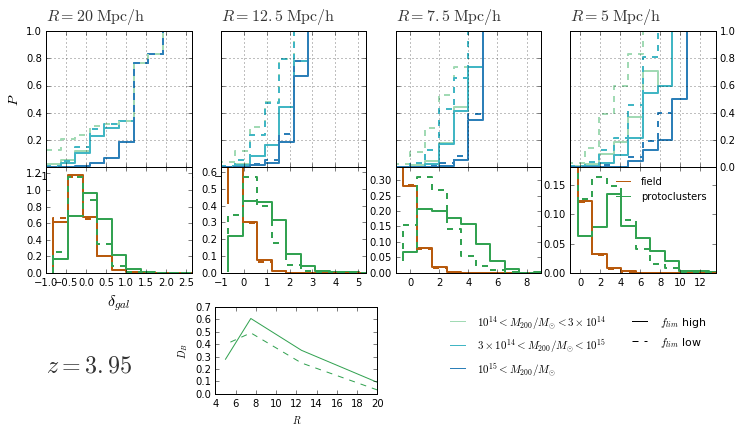

In [32]:
fig = plt.figure(figsize=(12,6.5))

gs1 = gridspec.GridSpec(24, 4)

gs1.update(hspace=0.)#, wspace=0) bottom = 0.57, top = 1, 

ax1 = fig.add_subplot(gs1[:9,0])
ax2 = fig.add_subplot(gs1[:9,1])
ax3 = fig.add_subplot(gs1[:9,2])
ax4 = fig.add_subplot(gs1[:9,3])

ax5 = fig.add_subplot(gs1[9:16,0])
ax6 = fig.add_subplot(gs1[9:16,1])
ax7 = fig.add_subplot(gs1[9:16,2])
ax8 = fig.add_subplot(gs1[9:16,3])

gs2 = gridspec.GridSpec(12, 16)
#gs2.update(bottom = 0.57, top = 1, hspace=0)#, wspace=0)

ax9 = fig.add_subplot(gs2[9:12, 4:8])

Bhatta = []
Bhatta_relaxed = []

redshift_str = '3.95'
redshift = '3p95'

ax5.text(0, -1.5, "$z = %s$" % redshift_str, transform = ax1.transAxes, size=24, alpha=0.8)

N = 12

for R, ax_up, ax_dw, limiting_fraction, limiting_fraction_relaxed in zip(['20', '12.5', '7.5', '5'], 
                                                                         [ax1, ax2, ax3, ax4], 
                                                                         [ax5, ax6, ax7, ax8], 
                                                                         [0.20, 0.55, 0.85, 0.95],
                                                                         [0.10, 0.40, 0.70, 0.80]):


    ax_up.text(0, 1.08, "$R = %s \; \mathrm{Mpc / h}$" % R, transform = ax_up.transAxes, size=16, alpha=0.8)

    dgal_max = max(dgal_random['delta_gal_%s'%R])   

    binLimits = np.linspace(-1, int(dgal_max)+1, N)

    lower_bin = binLimits[1] + (binLimits[0]-binLimits[1])/2 
    upper_bin = binLimits[-1] + (binLimits[0]-binLimits[1])/2

    bins = np.linspace(lower_bin, upper_bin, N-1)

    agg_data = aggregate_dgal(dgal_random, R, bins, limiting_fraction, lim_mass=1e4)
    agg_data.loc[np.isnan(agg_data['frac']), 'frac'] = 1
    ax_up.step(agg_data['bins'] - (bins[1]-bins[0])/2, agg_data['frac'], color=cmap_seq[1], linewidth=2)
    
    agg_data = aggregate_dgal(dgal_random, R, bins, limiting_fraction, lim_mass=3e4)
    agg_data.loc[np.isnan(agg_data['frac']), 'frac'] = 1
    ax_up.step(agg_data['bins'] - (bins[1]-bins[0])/2, agg_data['frac'], color=cmap_seq[2], linewidth=2)

    agg_data = aggregate_dgal(dgal_random, R, bins, limiting_fraction, lim_mass=1e5)
    agg_data.loc[np.isnan(agg_data['frac']), 'frac'] = 1
    ax_up.step(agg_data['bins'] - (bins[1]-bins[0])/2, agg_data['frac'], color=cmap_seq[3], linewidth=2)

    # relaxed limiting fraction
    agg_data = aggregate_dgal(dgal_random, R, bins, limiting_fraction_relaxed, lim_mass=1e4)
    agg_data.loc[np.isnan(agg_data['frac']), 'frac'] = 1
    ax_up.step(agg_data['bins'] - (bins[1]-bins[0])/2, agg_data['frac'], color=cmap_seq[1], linestyle='dashed', linewidth=2)

    agg_data = aggregate_dgal(dgal_random, R, bins, limiting_fraction_relaxed, lim_mass=3e4)
    agg_data.loc[np.isnan(agg_data['frac']), 'frac'] = 1
    ax_up.step(agg_data['bins'] - (bins[1]-bins[0])/2, agg_data['frac'], color=cmap_seq[2], linestyle='dashed', linewidth=2)

    agg_data = aggregate_dgal(dgal_random, R, bins, limiting_fraction_relaxed, lim_mass=1e5)
    agg_data.loc[np.isnan(agg_data['frac']), 'frac'] = 1
    ax_up.step(agg_data['bins'] - (bins[1]-bins[0])/2, agg_data['frac'], color=cmap_seq[3], linestyle='dashed', linewidth=2)


#     phiA, mass = np.histogram(dgal_random[(dgal_random['max_fraction_%s'%R] >= limiting_fraction) \
#                               & (dgal_random['max_fraction_mass_%s'%R] >= 1e4) \
#                               & (dgal_random['max_fraction_mass_%s'%R] < 3e4)]['delta_gal_%s'%R],
#                               bins=binLimits, normed=True)
#     ax_dw.step(bins, phiA, color=cmap_seq[1])
#     max_phi = max(phiA)

#     phiA, mass = np.histogram(dgal_random[(dgal_random['max_fraction_%s'%R] >= limiting_fraction) \
#                               & (dgal_random['max_fraction_mass_%s'%R] >= 3e4) \
#                               & (dgal_random['max_fraction_mass_%s'%R] < 1e5)]['delta_gal_%s'%R],
#                               bins=binLimits, normed=True)
#     ax_dw.step(bins, phiA, color=cmap_seq[2])
#     max_phi = max(max_phi, max(phiA))

#     phiA, mass = np.histogram(dgal_random[(dgal_random['max_fraction_%s'%R] >= limiting_fraction) \
#                               & (dgal_random['max_fraction_mass_%s'%R] >= 1e5)]['delta_gal_%s'%R],
#                               bins=binLimits, normed=True)
#     ax_dw.step(bins, phiA, color=cmap_seq[3])
#     max_phi = max(max_phi, max(phiA))

    for lfrac, bat, ls in zip([limiting_fraction, limiting_fraction_relaxed],[Bhatta, Bhatta_relaxed],['solid','dashed']):
        phiB, mass = np.histogram(dgal_random[(dgal_random['max_fraction_%s'%R] < lfrac) \
                                  | (dgal_random['max_fraction_mass_%s'%R] < 1e4)]['delta_gal_%s'%R],
                                  bins=binLimits, normed=True)
        ax_dw.step(bins, phiB, color=cmap[6], linewidth=2, linestyle=ls)

        phiA, mass = np.histogram(dgal_random[(dgal_random['max_fraction_%s'%R] >= lfrac) \
                                  & (dgal_random['max_fraction_mass_%s'%R] >= 1e4)]['delta_gal_%s'%R],
                                  bins=binLimits, normed=True)
        ax_dw.step(bins, phiA, color=cmap[0], linewidth=2, linestyle=ls)
        max_phi = max(phiA)

        DB, BC = hightolowz.bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))

        # ax_dw.text(0.64, 0.7, "$D_{B} = %.2f$" % DB, transform = ax_dw.transAxes)
        bat.append(DB)

#     if i == 0:
#         ax_up.text(0.05, 1.25, "$R=%s \, Mpc/h$" % str(round(float(R), 1)), transform = ax_up.transAxes)
#         ax_up.text(0.05, 1.1, "$f_{lim}=$ %.2f / %.2f" % (limiting_fraction, limiting_fraction_relaxed), transform = ax_up.transAxes)

    ax_up.grid()

    # ax_up.set_xlim(min(binLimits), max(binLimits))

    ax_dw.set_ylim(0, max_phi + max_phi/10)
    ax_dw.set_xlim(min(bins) - (bins[1]-bins[0])/2, max(bins) - (bins[1]-bins[0])/2)
    ax_up.set_xlim(min(bins) - (bins[1]-bins[0])/2, max(bins) - (bins[1]-bins[0])/2)

    
    
    
ax9.plot([20,12.5,7.5,5], Bhatta, color=cmap[0])
ax9.plot([20,12.5,7.5,5], Bhatta_relaxed, color=cmap[0], linestyle='dashed')
    
ax9.set_xlabel('$R$')
ax9.set_ylabel('$D_{B}$')
#ax9.vlines(7.5, 0, 0.7, colors='grey', linestyles='dotted')
    

ax5.set_xlabel('$\delta_{gal}$', size=16)
ax1.set_ylabel('$P$', size=14)
ax1.set_yticklabels(['','0.2','0.4','0.6','0.8','1.0'])


# for ax in [ax1, ax2, ax3, ax4]:
#     ax.set_xticklabels('')

for ax in [ax2, ax3]:
    ax.set_yticklabels('')
    
ax4.yaxis.tick_right()
    
line_field = plt.Line2D((0,1.5),(0,0), color=cmap[6], linestyle='solid', linewidth=1)
line_protocluster = plt.Line2D((0,1.5),(0,0), color=cmap[0], linestyle='solid', linewidth=1)
    
ax8.legend(handles=[line_field, line_protocluster], labels=['field', 'protoclusters'], prop={'size':10}, bbox_to_anchor=(1, 1), frameon=False)

line_small = plt.Line2D((0,1.5),(0,0), color=cmap_seq[1], linestyle='solid', linewidth=1)
line_medium = plt.Line2D((0,1.5),(0,0), color=cmap_seq[2], linestyle='solid', linewidth=1)
line_large = plt.Line2D((0,1.5),(0,0), color=cmap_seq[3], linestyle='solid', linewidth=1)

line_frac_hi = plt.Line2D((0,1.5),(0,0), color='black', linestyle='solid', linewidth=1)
line_frac_lo = plt.Line2D((0,1.5),(0,0), color='black', linestyle='dashed', linewidth=1)

ax3.legend(handles=[line_small, line_medium, line_large, line_frac_hi, line_frac_lo],
           labels=['$10^{14} < M_{200} / M_{\odot} < 3 \\times 10^{14}$','$3 \\times 10^{14} < M_{200} / M_{\odot} < 10^{15}$',
                   '$10^{15} < M_{200} / M_{\odot}$','$f_{lim}$ high','$f_{lim}$ low'], 
           prop={'size':11}, bbox_to_anchor=(2.2, -1), frameon=False, ncol=2)

# plt.savefig('../papers/hightolowz/images/gal_od_prob_%s_%s_single.png' % (redshift, selection), bbox_inches='tight', dpi=300)